# Tutorial for HisToGene pipeline

1. HisToGene training
2. HisToGene prediction
3. HisToGene super-resolution prediction

Please first download the data for this tutorial
```shell
cd data
git clone https://github.com/almaan/her2st.git
```

In [1]:
import os
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from vis_model import HisToGene
from utils import *
from predict import model_predict, sr_predict
from dataset import ViT_HER2ST, ViT_SKIN

## HisToGene training

In [2]:
fold = 5
tag = '-htg_her2st_785_32_cv'

dataset = ViT_HER2ST(train=True, fold=fold)
train_loader = DataLoader(dataset, batch_size=1, num_workers=4, shuffle=True)
model = HisToGene(n_layers=8, n_genes=785, learning_rate=1e-5)
trainer = pl.Trainer(gpus=0, max_epochs=100)
trainer.fit(model, train_loader)
trainer.save_checkpoint("model/last_train_"+tag+'_'+str(fold)+".ckpt")

Loading imgs...
Loading metadata...


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name            | Type       | Params
-----------------------------------------------
0 | patch_embedding | Linear     | 38.5 M
1 | x_embed         | Embedding  | 35.8 K
2 | y_embed         | Embedding  | 35.8 K
3 | vit             | ViT        | 67.2 M
4 | gene_head       | Sequential | 806 K 
-----------------------------------------------
106 M     Trainable params
0         Non-trainable params
106 M     Total params
426.356   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

## HisToGene prediction

In [12]:
fold = 5
tag = '-htg_her2st_785_32_cv'

model = HisToGene.load_from_checkpoint("model/last_train_"+tag+'_'+str(fold)+".ckpt",n_layers=8, n_genes=785, learning_rate=1e-5)
device = torch.device('cpu')
dataset = ViT_HER2ST(train=False,sr=False,fold=fold)
test_loader = DataLoader(dataset, batch_size=1, num_workers=4)
adata_pred, adata_truth = model_predict(model, test_loader, attention=False, device = device)
adata_pred = comp_tsne_km(adata_pred,4)

g = list(np.load('data/her_hvg_cut_1000.npy',allow_pickle=True))
adata_pred.var_names = g
sc.pp.scale(adata_pred)
adata_pred

Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


AnnData object with n_obs × n_vars = 295 × 785
    obs: 'kmeans'
    var: 'mean', 'std'
    uns: 'pca', 'tsne'
    obsm: 'spatial', 'X_pca', 'X_tsne'
    varm: 'PCs'

We can visualize the results.

... storing 'kmeans' as categorical


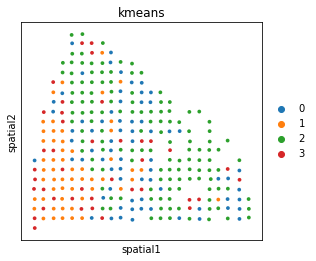

In [13]:

sc.pl.spatial(adata_pred, img=None, color='kmeans', spot_size=112)

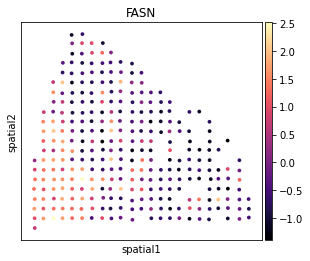

In [18]:
sc.pl.spatial(adata_pred, img=None, color='FASN', spot_size=112, color_map='magma')

## Super-resolution gene expression prediction

In [15]:
dataset_sr = ViT_HER2ST(train=False,sr=True,fold=fold)
test_loader_sr = DataLoader(dataset_sr, batch_size=1, num_workers=2)
adata_sr = sr_predict(model,test_loader_sr,attention=False)
adata_sr = comp_tsne_km(adata_sr,4)

g = list(np.load('data/her_hvg_cut_1000.npy',allow_pickle=True))
adata_sr.var_names = g
sc.pp.scale(adata_sr)
adata_sr

Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:53<00:00, 53.70s/it]


AnnData object with n_obs × n_vars = 11960 × 785
    obs: 'kmeans'
    var: 'mean', 'std'
    uns: 'pca', 'tsne'
    obsm: 'spatial', 'X_pca', 'X_tsne'
    varm: 'PCs'

We can visualize the super-resolution results.

... storing 'kmeans' as categorical


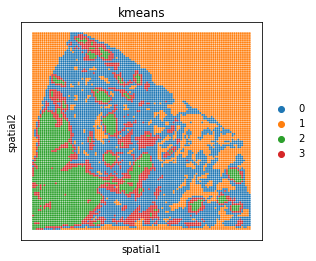

In [16]:
sc.pl.spatial(adata_sr, img=None, color='kmeans', spot_size=56)

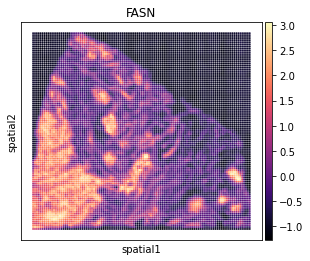

In [19]:
sc.pl.spatial(adata_sr, img=None, color='FASN', spot_size=56, color_map='magma')